# BinWaves example in Cantabria (Propagation)

**In this notebook**: 
<br><br>
Here is where the construction of the library of pre-run cases for all the monochromatic wave systems is made.
<br><br>
Steps:
- Generates wave conditions for all given frequencies and directions.
- Generates SWAN cases and runs them.
- Extracts SWAN cases and saves output.
- Plots the library for all the cases and some larger example ones.

## Generate computational bathymetry

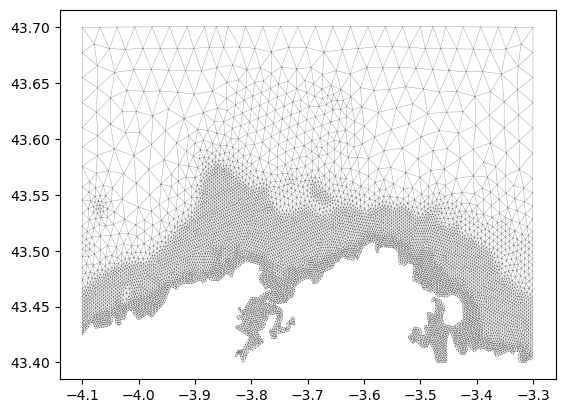

In [1]:
import matplotlib.pyplot as plt
from bluemath_tk.topo_bathy.mesh_utils import read_adcirc_grd


Nodes_calc, Elmts_calc, lines_calc = read_adcirc_grd("inputs/Cantabria_mesh_adcirc.grd")
fig, ax = plt.subplots()
ax.triplot(
    Nodes_calc[:, 1],
    Nodes_calc[:, 2],
    Elmts_calc[:, 2:5],
    color="grey",
    linestyle="-",
    marker="",
    linewidth=1 / 4,
)

## Create SWAN cases

In [2]:
from bluemath_tk.waves.binwaves import generate_swan_cases
from utils.wrapper import example_directions, example_frequencies


# Generate swan model parameters
example_directions = example_directions[:7] + example_directions[-7:]
swan_cases_df = (
    generate_swan_cases(
        directions_array=example_directions,
        frequencies_array=example_frequencies,
    )
    .astype(float)
    .to_dataframe()
    .reset_index()
)
swan_cases_df

,dir,freq,hs,tp,spr,gamma
0,7.5,0.035000,1.0,28.5714,2.0,50.0
1,7.5,0.038500,1.0,25.9740,2.0,50.0
2,7.5,0.042350,1.0,23.6128,2.0,50.0
3,7.5,0.046585,1.0,21.4661,2.0,50.0
4,7.5,0.051243,1.0,19.5147,2.0,50.0
...,...,...,...,...,...,...
401,352.5,0.344741,0.1,2.9007,2.0,50.0
402,352.5,0.379215,0.1,2.6370,2.0,50.0
403,352.5,0.417136,0.1,2.3973,2.0,50.0
404,352.5,0.458850,0.1,2.1794,2.0,50.0


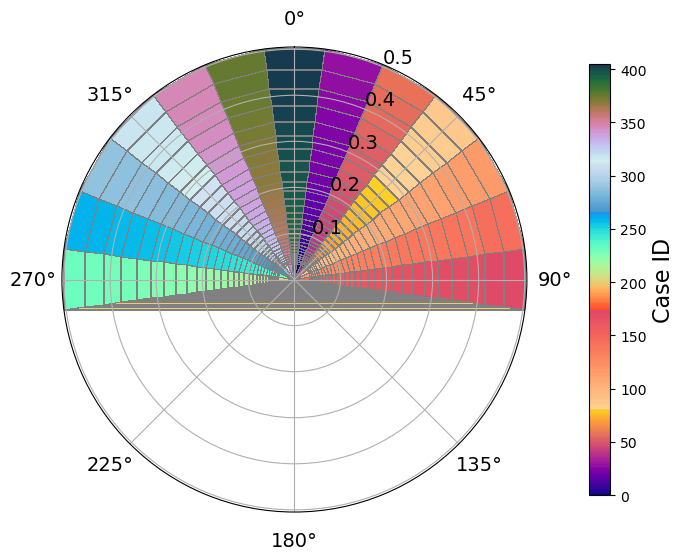

In [3]:
import numpy as np
from bluemath_tk.waves.binwaves import plot_selected_cases_grid


# Plot the cases grid

plot_selected_cases_grid(
    frequencies=np.array(example_frequencies),
    directions=np.array(example_directions),
    figsize=(8, 8),
)

## Build and run SWAN cases

In [4]:
import os
from utils.wrapper import BinWavesWrapper


# Define the input templates and output directory for the wrapper

templates_dir = os.path.join(os.getcwd(), "templates/nostruc")
output_dir = os.path.join(os.getcwd(), "CAN_cases")

# Create an instance of the SWAN model wrapper

swan_wrapper = BinWavesWrapper(
    templates_dir=templates_dir,
    metamodel_parameters=swan_cases_df.to_dict(orient="list"),
    fixed_parameters={},
    output_dir=output_dir,
)

2025-05-07 12:28:43,711 - BinWavesWrapper - WARNING - Parameter dir is not in the default_parameters
2025-05-07 12:28:43,712 - BinWavesWrapper - WARNING - Parameter freq is not in the default_parameters
2025-05-07 12:28:43,712 - BinWavesWrapper - WARNING - Parameter hs is not in the default_parameters
2025-05-07 12:28:43,712 - BinWavesWrapper - WARNING - Parameter tp is not in the default_parameters
2025-05-07 12:28:43,713 - BinWavesWrapper - WARNING - Parameter spr is not in the default_parameters
2025-05-07 12:28:43,713 - BinWavesWrapper - WARNING - Parameter gamma is not in the default_parameters


In [5]:
# Build the input files

swan_wrapper.build_cases(mode="one_by_one")
swan_cases_df.to_csv(os.path.join(output_dir, "swan_cases.csv"), index=False)

In [6]:
# Run the model

swan_wrapper.run_cases_in_background(launcher="docker_serial", num_workers=10)

In [60]:
# Monitor running cases

swan_wrapper.monitor_cases()

,Case,Status
0,0000,99.50 %
1,0001,100 %
2,0002,100 %
3,0003,100 %
4,0004,100 %
...,...,...
401,0401,100 %
402,0402,100 %
403,0403,100 %
404,0404,100 %


In [61]:
# Post-process the output files

cases_bulk_parameters = swan_wrapper.postprocess_cases()
cases_bulk_parameters

<xarray.Dataset> Size: 39MB
Dimensions:   (case_num: 406, Yp: 1, Xp: 7965)
Coordinates:
  * Xp        (Xp) float32 32kB -4.1 -4.1 -4.1 -4.1 -4.1 ... -3.3 -3.3 -3.3 -3.3
  * Yp        (Yp) float32 4B 43.42
  * case_num  (case_num) int64 3kB 0 1 2 3 4 5 6 ... 399 400 401 402 403 404 405
Data variables:
    Hsig      (case_num, Yp, Xp) float32 13MB 2.94 1.093 ... 0.06764 0.06765
    Tm02      (case_num, Yp, Xp) float32 13MB 28.61 28.61 28.61 ... 1.283 1.282
    Dir       (case_num, Yp, Xp) float32 13MB 262.1 262.0 261.9 ... 277.5 277.5

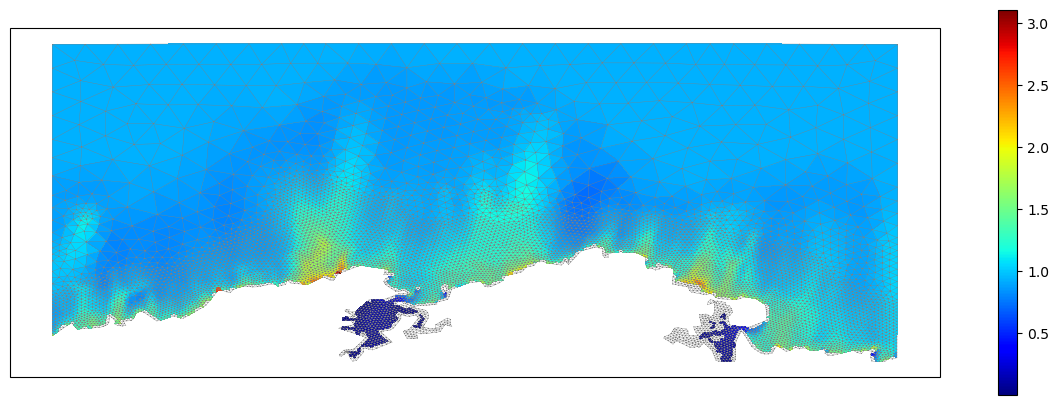

In [ ]:
from scipy.io import loadmat
import cartopy.crs as ccrs


hsig = loadmat(
    "/home/tausiaj/GitHub-GeoOcean/BlueMath/methods/hybrid_downscaling/additive/BinWaves/CAN_cases/0000/output.mat"
)["Hsig"]
hsig_triangles = np.mean(hsig.reshape(-1)[Elmts_calc[:, 2:5].astype(int)], axis=1)

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(15, 5))

pm = ax.tripcolor(
    Nodes_calc[:, 1],
    Nodes_calc[:, 2],
    Elmts_calc[:, 2:5],
    facecolors=hsig_triangles,
    transform=ccrs.PlateCarree(),
    cmap="jet",
)
fig.colorbar(pm)
ax.triplot(
    Nodes_calc[:, 1],
    Nodes_calc[:, 2],
    Elmts_calc[:, 2:5],
    color="grey",
    linestyle="-",
    marker="",
    linewidth=1 / 4,
    transform=ccrs.PlateCarree(),
)

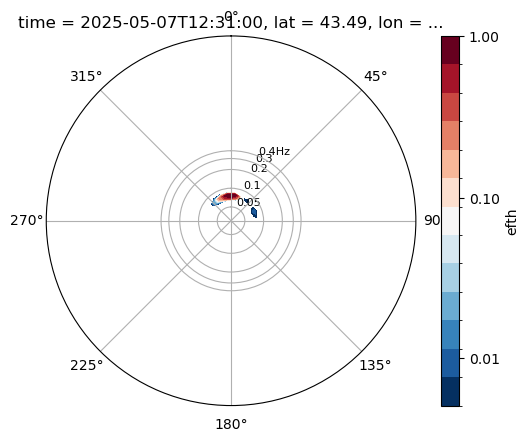

In [28]:
from wavespectra.input.swan import read_swan


read_swan(
    "/home/tausiaj/GitHub-GeoOcean/BlueMath/methods/hybrid_downscaling/additive/BinWaves/CAN_cases/0008/output.spec"
).efth.squeeze().spec.plot()

AttributeError: Line2D.set() got an unexpected keyword argument 'cbar_kwargs'

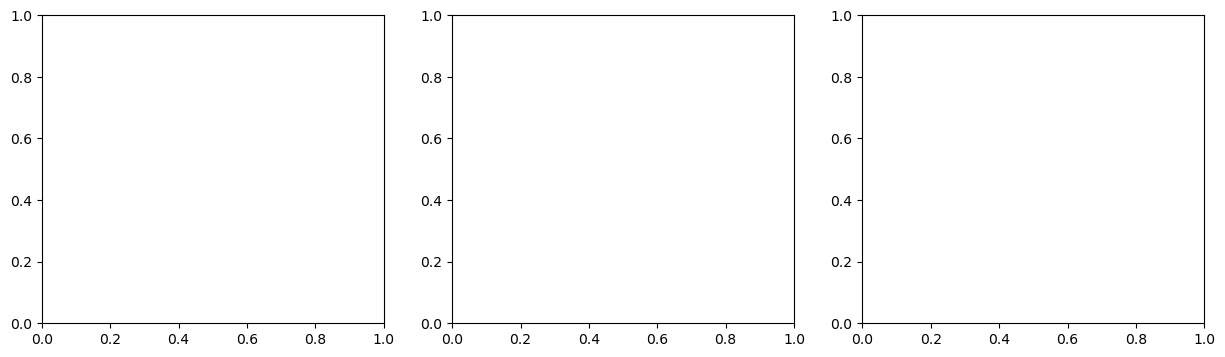

In [62]:
from utils.plotting import plot_case_variables

plot_case_variables(
    data=cases_bulk_parameters.isel(case_num=20),
)

## Plot ALL pre-run cases

/opt/conda/lib/python3.12/site-packages/matplotlib/colors.py:2294: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


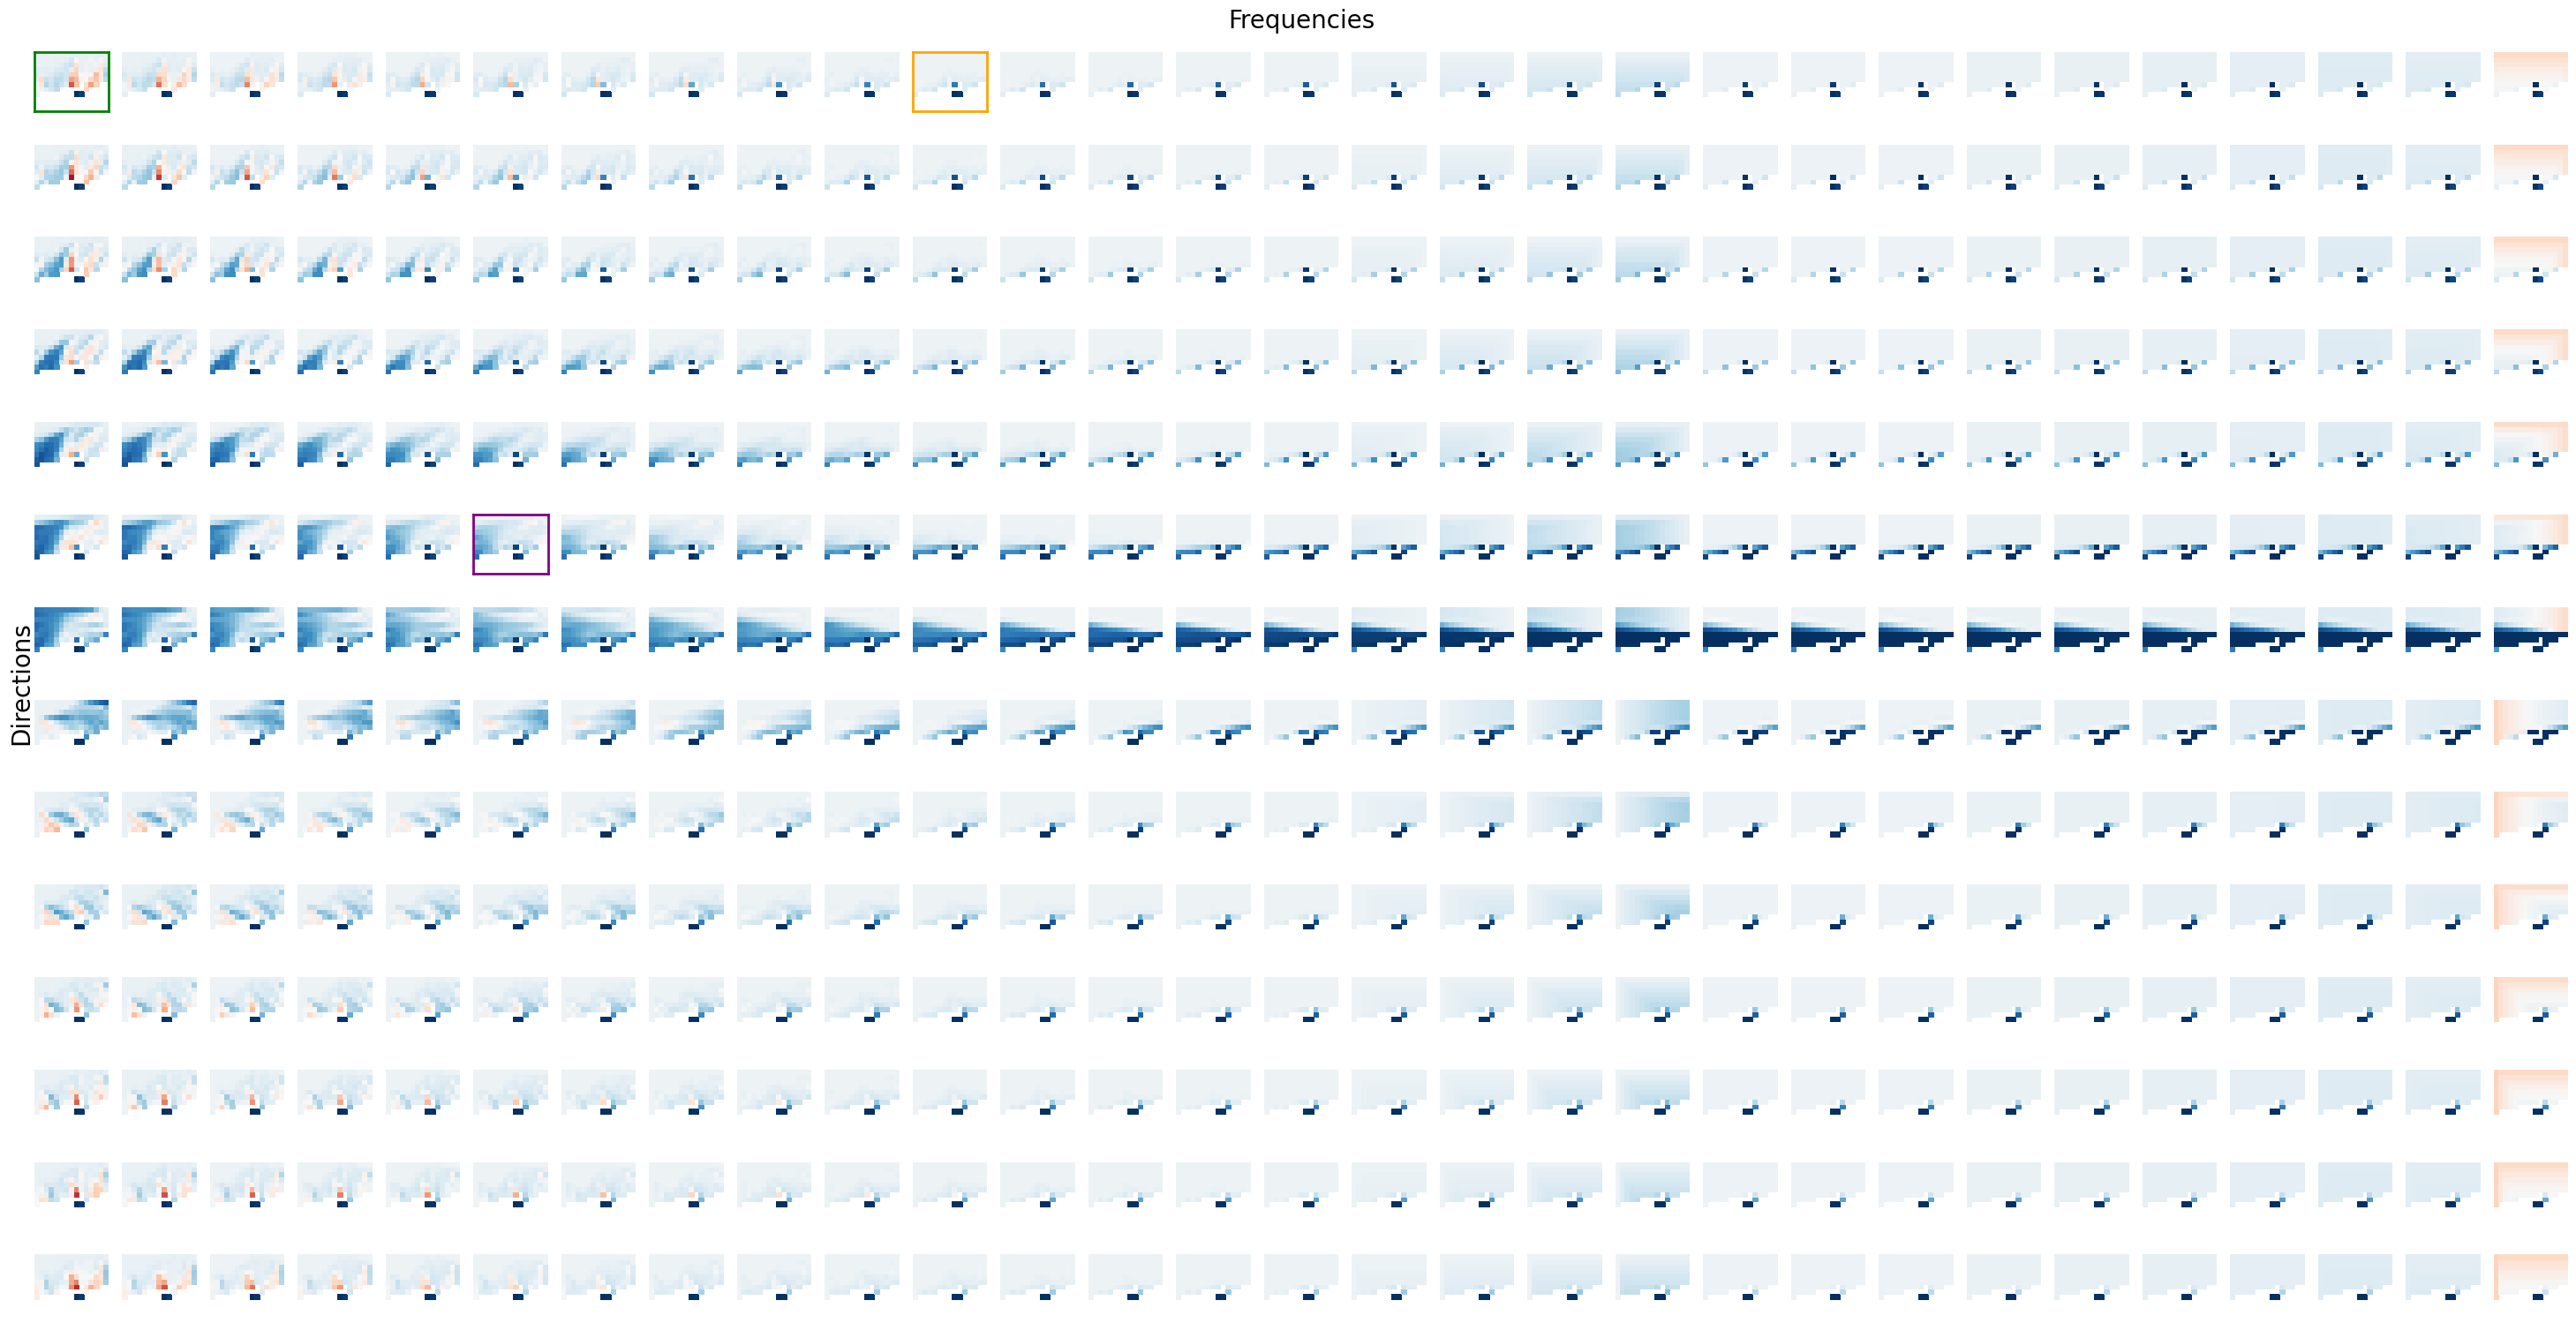

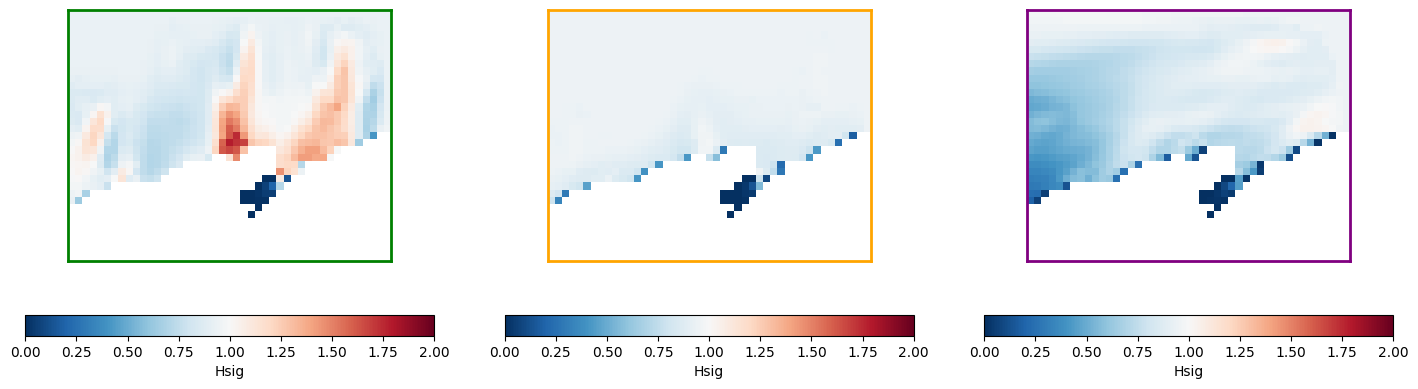

In [13]:
from utils.plotting import plot_cases_grid

plot_cases_grid(
    data=cases_bulk_parameters.Hsig.where(
        cases_bulk_parameters.case_num.isin(
            swan_cases_df.where(swan_cases_df["hs"] == 1.0).dropna().index.values
        ),
        cases_bulk_parameters.Hsig * 10,
    ),
    cases_to_plot=[0, 10, 150],
    num_directions=len(example_directions),
    num_frequencies=len(example_frequencies),
)

## Extract kp coefficients

In [ ]:
# ps aux | grep python
# pkill -f "python"

In [9]:
from bluemath_tk.waves.binwaves import process_kp_coefficients

list_of_input_spectra = [
    os.path.join(case_dir, "input_spectra_N.bnd")
    for case_dir in swan_wrapper.cases_dirs
]
list_of_output_spectra = [
    os.path.join(case_dir, "output.spec") for case_dir in swan_wrapper.cases_dirs
]

kp_coefficients = process_kp_coefficients(
    list_of_input_spectra=list_of_input_spectra,
    list_of_output_spectra=list_of_output_spectra,
)
kp_coefficients

<xarray.DataArray 'efth' (case_num: 406, site: 286, freq: 31, dir: 24)> Size: 691MB
array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          3.99747617e-02, 1.46505053e-01, 1.19585197e-01],
         [3.22134037e-03, 0.00000000e+00, 3.76764955e-05, ...,
          3.88067904e-02, 1.76043425e-01, 1.86517491e-01],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 3.49785162e-04, ...,
          6.03688038e-02, 1.63658304e-01, 9.85159620e-02],
         [0.00000000e+00, 0.00000000e+00, 1.87237939e-03, ...,
          6.09860717e-02, 2.03718993e-01, 1.60777721e-01],
...
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 6.05835047e-01]]]])
Coordinates:
  * case_num  (case_num) int64 3kB 0 1 2 3 4 5 6 ... 399 400 401 402 403 404 405
  * site      (site) int64 2kB 1 2 3 4 5 6 7 8 ... 280 281 282 283 284 285 286
  * freq      (freq) float64 248B 0.03 0.0329 0.0362 ... 0.4145 0.4552 0.5
  * dir       (dir) float64 192B 7.5 22.5 37.5 52.5 ... 307.5 322.5 337.5 352.5
    time      datetime64[ns] 8B 2025-04-02T14:54:00
    lat       float64 8B 0.0
    lon       float64 8B 0.0

In [ ]:
kp_coefficients.to_dataset(name="kps").drop(["time", "lat", "lon"]).assign_coords(
    utm_x=(("site"), swan_wrapper.locations[:, 0]),
    utm_y=(("site"), swan_wrapper.locations[:, 1]),
).to_netcdf("outputs/kp_coefficients.nc")

/tmp/ipykernel_26182/2395593079.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  kp_coefficients.to_dataset(name="kps").drop(["time", "lat", "lon"]).assign_coords(


: 